In [1]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid, save_image
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
# import resnet_cifar10 as RN_cifar

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device = 'cuda'

import shutil
import time
 
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
# import resnet as RN
# import pyramidnet as PYRM
# from allcnn import AllConvNet
 
import warnings
 
warnings.filterwarnings("ignore")

In [2]:
dataset = 'imagenet'
depth = 18
pretrained_vanilla = 'runs/imagenet/vanilla/model_best.pth.tar' #-------------------------------------change
pretrained_clewr = 'runs/imagenet/curr_exp/model_best.pth.tar'#------------------------------------------change
numberofclass = 1000

In [3]:
# Load vanilla model
# model1 = RN.ResNet(dataset=dataset, depth=depth, num_classes=numberofclass, bottleneck=True) #-----------------------check once
model1 = models.__dict__['resnet18']()
# model1 = RN_cifar.__dict__['resnet20']()
model1 = torch.nn.DataParallel(model1)
print("=> loading checkpoint '{}'".format(pretrained_vanilla))
checkpoint = torch.load(pretrained_vanilla, map_location=torch.device('cpu'))
model1.load_state_dict(checkpoint['state_dict'], strict=False)
print("=> loaded checkpoint '{}'".format(pretrained_vanilla))

# print(model)
print('the number of model parameters: {}'.format(sum([p.data.nelement() for p in model1.parameters()])))
model1.to(device).eval()


=> loading checkpoint 'runs/imagenet/vanilla/model_best.pth.tar'
=> loaded checkpoint 'runs/imagenet/vanilla/model_best.pth.tar'
the number of model parameters: 11689512


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [4]:
# Load clewr model
# model2 = RN.ResNet(dataset=dataset, depth=depth, num_classes=numberofclass, bottleneck=True) 
model2 = models.__dict__['resnet18']()
model2 = torch.nn.DataParallel(model2)

print("=> loading checkpoint '{}'".format(pretrained_clewr))
checkpoint = torch.load(pretrained_clewr, map_location=torch.device('cpu') )
model2.load_state_dict(checkpoint['state_dict'], strict=False)
print("=> loaded checkpoint '{}'".format(pretrained_clewr))

print('the number of model parameters: {}'.format(sum([p.data.nelement() for p in model2.parameters()])))
model2.to(device).eval()

=> loading checkpoint 'runs/imagenet/curr_exp/model_best.pth.tar'
=> loaded checkpoint 'runs/imagenet/curr_exp/model_best.pth.tar'
the number of model parameters: 11689512


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [5]:
selected_filter = 0
def hook_function(module, grad_in, grad_out):
    # Gets the conv output of the selected filter (from selected layer)
    conv_output = grad_out[0, selected_filter]
model1.module.conv1.register_forward_hook(hook_function)

Total convolutional layers: 17


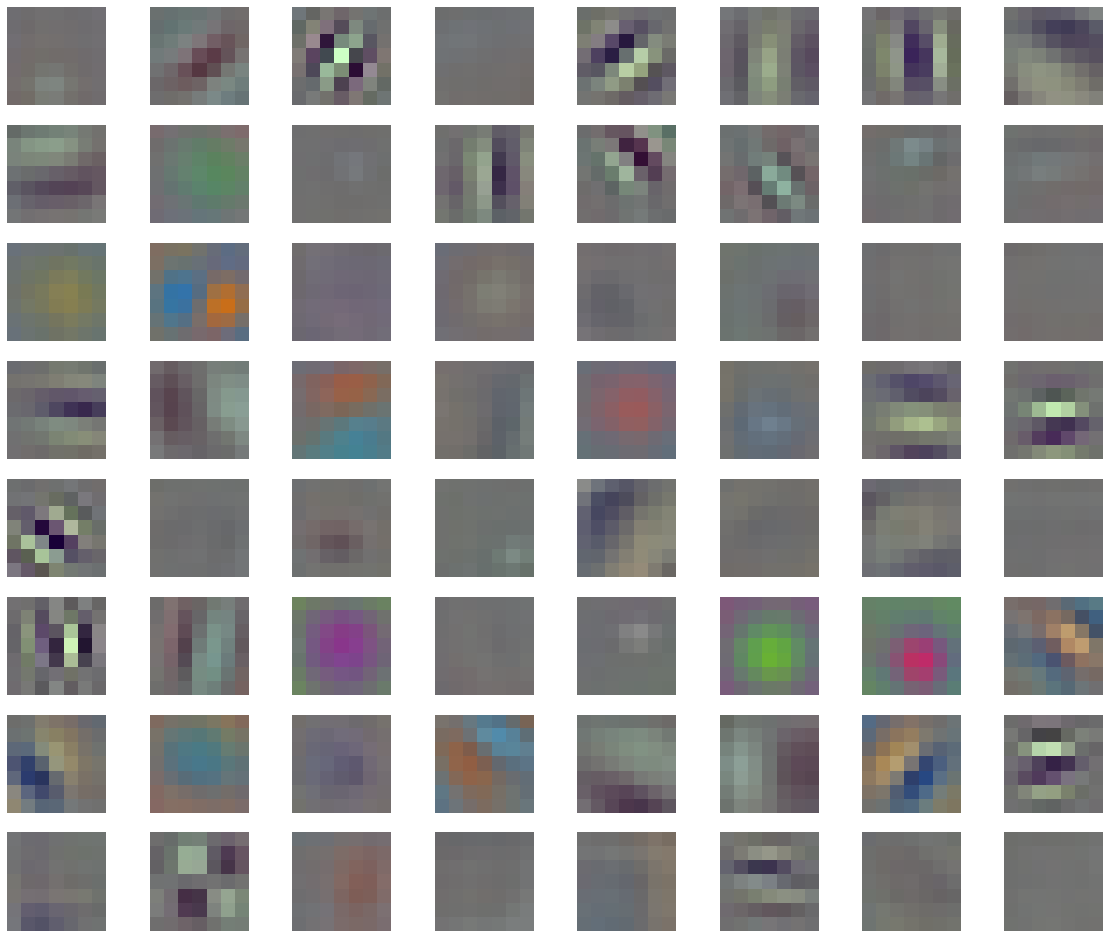

In [33]:
model = model1.module
model_weights = [] 
conv_layers = [] 
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

# for weight, conv in zip(model_weights, conv_layers):
#     # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
#     print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

# visualize the first conv layer filters
model_weights[0] = ((model_weights[0]-model_weights[0].min())/(model_weights[0].max()-model_weights[0].min()))
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter.permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.savefig('filter1.png')
plt.show()

Total convolutional layers: 17


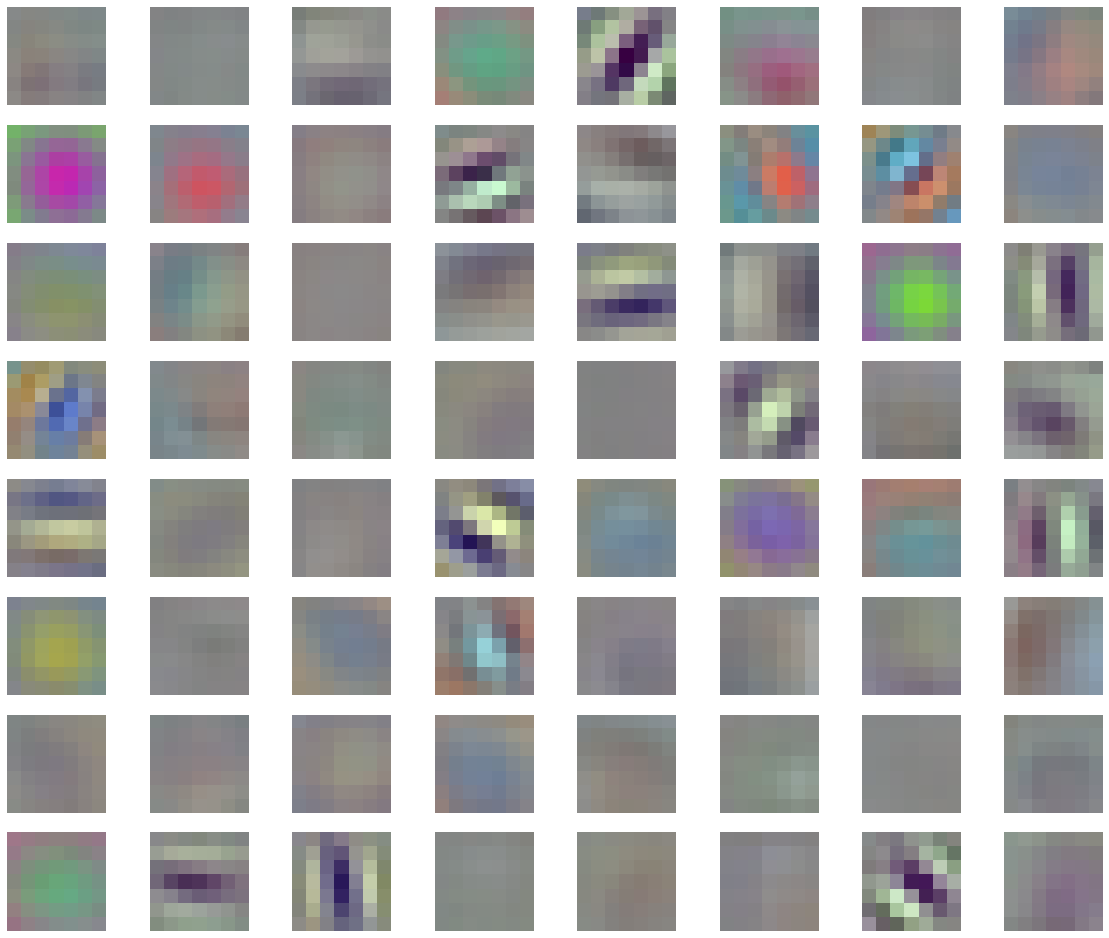

In [32]:
model = model2.module
model_weights = [] 
conv_layers = [] 
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
model_weights[0] = ((model_weights[0]-model_weights[0].min())/(model_weights[0].max()-model_weights[0].min()))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter.permute(1, 2, 0).detach().cpu().numpy())
    plt.axis('off')
    plt.savefig('filter1.png')
plt.show()

In [28]:
((model_weights[0]-model_weights[0].min())/(model_weights[0].max()-model_weights[0].min())).max()

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)